# Amazon Book Review Text Analysis
****
This project uses Amazon book review data obtained from UCSD to achieve the following:

1) Understand how favorably readers find books on average from the star rating system and determine the most frequently used words and bi-grams in review text.

2) Create a Naive Bayes model to predict star rating of review based on textual analysis.

3) Recommend books based on topics determined through LDA that are included in favorable reviews by the user.

## Data Importation

In [1]:
from __future__ import with_statement
import pandas as pd
import time
import threading

def readProducts(path, reviews, reviewsLock, released, releasedLock, products, productsLock, merged, mergedLock):
  #open the file at the specified path
  with open(path, 'rb') as f:
    
    #For every line in the compressed file
    for line in f:
        if len(merged) < 500000: #set limit of a million reviews read in
            lineDict = eval(line)

            #get the product key
            asin = str(lineDict.get('asin'))
            if asin == None:
              del asin
              del lineDict
              del line
              continue

            #get the categories
            categories = lineDict.get('categories')

            #if categories exists and 'books' is not a category for the product, we can discard the product
            if categories != None:
                #sanitize the categories into lowercase (for some reason categories is a list of lists that is always length 1
                sanitizedCategories = [x.lower() for x in categories[0]]

                #if books is not in categories, skip this product and delete the vars created, free mem
                if 'books' not in sanitizedCategories:
                    del lineDict
                    del line
                    del asin
                    del categories
                    del sanitizedCategories
                    continue
                #otherwise delete the categories objects to free memory
                else:
                    del categories
                    del sanitizedCategories

            #if the asin has been released by the review processor, merge it
            if asin in released:

                #remove released asin from released list to free memory
                with releasedLock:
                    released.remove(asin)

                #for each review that has been processed, merge in metadata
                for review in reviews[asin]:
                    updatedReview = getWantedDataFromReviewAndProduct(review, lineDict)

                    with mergedLock:
                      merged.append(updatedReview)

                    #cleanup
                    del updatedReview
                    del review

                with reviewsLock:
                    del reviews[asin]
            else:
                #otherwise, add relevant product metadata to product dict
                with productsLock:
                    products[asin] = {'title': lineDict.get('title')}

            #cleanup objects in memory immediately
            del lineDict
            del asin
            del line
        else:
            break

def readReviews(path, reviews, reviewsLock, released, releasedLock, products, productsLock, merged, mergedLock):
  #open the file at the specified path
  with open(path, 'rb') as f:
    
    #for every line in the compressed file
    previousAsin = 'Initial'
    
    
    for line in f:
        if len(merged) < 500000:
            lineDict = eval(line)

            #get the product key
            asin = str(lineDict.get('asin'))
            if asin == None:
                del lineDict
                del line
                continue

            if asin in reviews:
                #if the product key is already in the reviews map, append the new review
                with reviewsLock:
                    reviews[asin].append(lineDict)
            else:
                #otherwise add this review as the first in the dict
                with reviewsLock:
                    reviews[asin] = [lineDict]

            if previousAsin != asin:
                #if previous asin is different from the next, we've added all reviews for that asin since file is organized by asin 

                #if the preivous asin has been read into products
                if previousAsin in products:

                    #get the product metadata
                    productMetadata = products.get(previousAsin)

                    #cleanup processed product, free memory
                    with productsLock:
                        del products[previousAsin]

                    #for each review we've read, merge in metadata and add to merged list
                    for review in reviews[previousAsin]:
                        updatedReview = getWantedDataFromReviewAndProduct(review, productMetadata)

                        with mergedLock:
                            merged.append(updatedReview)

                        #cleanup and free memory
                        del updatedReview
                        del review

                    #cleanup processed reviews, free memory
                    with reviewsLock:
                        del reviews[previousAsin]

                    del productMetadata
                else:
                    #if product has not been read in yet, add asin to released asins to be processed later
                    with releasedLock:
                        released.add(previousAsin)

            #set the newest asin
            previousAsin = str(asin)

            #cleanup and free memory
            del line
            del lineDict
        else:
            break
            
def getWantedDataFromReviewAndProduct(review, product):
    minimized = {}
    
    minimized['reviewerID'] = review.get('reviewerID')
    minimized['asin'] = review.get('asin')
    minimized['reviewerName'] = review.get('reviewerName')
    minimized['helpful'] = review.get('helpful')
    minimized['reviewText'] = review.get('reviewText')
    minimized['overall'] = review.get('overall')
    minimized['summary'] = review.get('summary')
    
    minimized['title'] = product.get('title')
    
    return minimized
    

#Start the timer
start = time.time()

#Initialize reviews dict and lock
reviews = {}
reviewsLock = threading.Lock()

#Initialize products dict and lock
products = {}
productsLock = threading.Lock()

#Initialize released reviews set and lock
releasedReviews = set()
releasedReviewsLock = threading.Lock()

#Initialize merged reviews list and lock
merged = []
mergedLock = threading.Lock()

#Create the thread which will process reviews
reviewsThread = threading.Thread(target=readReviews, 
                                 args=(
                                     'D:/Springboard/Capstone2_Data/reviews_books/reviews_books.json', 
                                     reviews, 
                                     reviewsLock,
                                     releasedReviews,
                                     releasedReviewsLock,
                                     products,
                                     productsLock,
                                     merged,
                                     mergedLock))

#Create the thread to process products
productsThread = threading.Thread(target=readProducts, 
                                 args=(
                                     'D:/Springboard/Capstone2_Data/metadata/metadata.json', 
                                     reviews, 
                                     reviewsLock,
                                     releasedReviews,
                                     releasedReviewsLock,
                                     products,
                                     productsLock,
                                     merged,
                                     mergedLock))

#Start concurrent threads
reviewsThread.start()
productsThread.start()

#Wait for threads to complete work and print status messages in increments
i = 0
while reviewsThread.isAlive() or productsThread.isAlive():
    if i % 3000000 == 0:
        print ('Waiting... Reviews: ' + str(len(reviews)) + ', Products: ' + str(len(products)) + ', Merged: ' + str(len(merged)))
        i += 1
        pass
    else:
        i += 1
        pass

#Mark the end of processing time
end = time.time()

#print information about the processed resources
print('Reviews Length: ' + str(len(reviews)))
print('Products Length: ' + str(len(products)))
print('Merged Length: ' + str(len(merged)))
print('\nExample: ' + str(merged[0]) + '\n')

#Calculate how long it took for this script to run
elapsed = end - start

#Print final run time in seconds
print('Elapsed Time in Seconds: ' + str(elapsed))

Waiting... Reviews: 0, Products: 0, Merged: 0
Waiting... Reviews: 1, Products: 13569, Merged: 9380
Waiting... Reviews: 1, Products: 18930, Merged: 12794
Waiting... Reviews: 1, Products: 23213, Merged: 17502
Waiting... Reviews: 1, Products: 26180, Merged: 20921
Waiting... Reviews: 1, Products: 30004, Merged: 27192
Waiting... Reviews: 1, Products: 31140, Merged: 32091
Waiting... Reviews: 1, Products: 33550, Merged: 36578
Waiting... Reviews: 1, Products: 39135, Merged: 47231
Waiting... Reviews: 1, Products: 42069, Merged: 50769
Waiting... Reviews: 1, Products: 46691, Merged: 53344
Waiting... Reviews: 1, Products: 61554, Merged: 79206
Waiting... Reviews: 1, Products: 68710, Merged: 98965
Waiting... Reviews: 1, Products: 86083, Merged: 140205
Waiting... Reviews: 1, Products: 108818, Merged: 200100
Waiting... Reviews: 1, Products: 127162, Merged: 224805
Waiting... Reviews: 1, Products: 133957, Merged: 233377
Waiting... Reviews: 1, Products: 142469, Merged: 252474
Waiting... Reviews: 1, Produ

In [2]:
del products, releasedReviews, reviews

#Convert to dataframe
reviews_df = pd.DataFrame(merged)

del merged

In [3]:
reviews_df.head()

,asin,helpful,overall,reviewText,reviewerID,reviewerName,summary,title
0,000100039X,"[0, 0]",5.0,Spiritually and mentally inspiring! A book tha...,A10000012B7CGYKOMPQ4L,Adam,Wonderful!,The Prophet
1,000100039X,"[0, 2]",5.0,This is one my must have books. It is a master...,A2S166WSCFIFP5,"adead_poet@hotmail.com ""adead_poet@hotmail.com""",close to god,The Prophet
2,000100039X,"[0, 0]",5.0,This book provides a reflection that you can a...,A1BM81XB4QHOA3,"Ahoro Blethends ""Seriously""",Must Read for Life Afficianados,The Prophet
3,000100039X,"[0, 0]",5.0,I first read THE PROPHET in college back in th...,A1MOSTXNIO5MPJ,Alan Krug,Timeless for every good and bad time in your l...,The Prophet
4,000100039X,"[7, 9]",5.0,A timeless classic. It is a very demanding an...,A2XQ5LZHTD4AFT,Alaturka,A Modern Rumi,The Prophet


In [4]:
print('Number of reviews:', len(reviews_df))
print('Number of books reviewed:', len(reviews_df.asin.value_counts()))
print('Number of unique readers:', len(reviews_df.reviewerID.value_counts()))

Number of reviews: 500005
Number of books reviewed: 12284
Number of unique readers: 214608


## Data Cleaning

In [5]:
#Combine summary into review text for full text analysis
reviews_df['full_text'] = reviews_df.summary + '. ' + reviews_df.reviewText

del reviews_df['summary']
del reviews_df['reviewText']

reviews_df.head()

,asin,helpful,overall,reviewerID,reviewerName,title,full_text
0,000100039X,"[0, 0]",5.0,A10000012B7CGYKOMPQ4L,Adam,The Prophet,Wonderful!. Spiritually and mentally inspiring...
1,000100039X,"[0, 2]",5.0,A2S166WSCFIFP5,"adead_poet@hotmail.com ""adead_poet@hotmail.com""",The Prophet,close to god. This is one my must have books. ...
2,000100039X,"[0, 0]",5.0,A1BM81XB4QHOA3,"Ahoro Blethends ""Seriously""",The Prophet,Must Read for Life Afficianados. This book pro...
3,000100039X,"[0, 0]",5.0,A1MOSTXNIO5MPJ,Alan Krug,The Prophet,Timeless for every good and bad time in your l...
4,000100039X,"[7, 9]",5.0,A2XQ5LZHTD4AFT,Alaturka,The Prophet,A Modern Rumi. A timeless classic. It is a ve...


In [6]:
#Read a review
reviews_df.full_text[34589]

"Great book!!. This was another great book in the divergent series. I love the entire series definitely recommend. I'm a pretty picky reader, the Divergent series is worth reading."

In [7]:
#Check data types
reviews_df.dtypes

asin             object
helpful          object
overall         float64
reviewerID       object
reviewerName     object
title            object
full_text        object
dtype: object

## Data Exploration

Let's explore how these reviews are split between favorable and unfavorable reviews.  I consider a review with a rating of 3.0 to be neutral, 4.0 or above favorable, and 2.0 or below unfavorable.  Half-stars for individual reviews are not possible.

In [8]:
print('Pct of favorable reviews (4.0 or higher): {:.2f}'.format(reviews_df[reviews_df.overall >= 4.0].size * 100 / reviews_df.size))
print('Pct of unfavorable reviews (2.0 or lower): {:.2f}'.format(reviews_df[reviews_df.overall <= 2.0].size * 100 / reviews_df.size))

Pct of favorable reviews (4.0 or higher): 78.46
Pct of unfavorable reviews (2.0 or lower): 9.43


It appears that either readers more often buy books they know they'll enjoy or only take the time to write a review if they find the book engaging.  We can also determine if certain users more reliably rate favorably or if reviews are mixed for most users.

In [778]:
#Group by reviewer ID, find mean of their ratings and sorts into 5 bins (one for each star rating)
g = reviews_df.groupby('reviewerID')['overall'].mean().value_counts(bins = 5).sort_index(ascending = False)
g.index = ['Average rating of 5 stars','Average rating of 4 stars','Average rating of 3 stars','Average rating of 2 stars','Average rating of 1 stars']
g = g.to_frame()
g = g.assign(pct = g.overall * 100 / g.overall.sum())
print(g)

                           overall        pct
Average rating of 5 stars   123269  57.439145
Average rating of 4 stars    51865  24.167319
Average rating of 3 stars    21111   9.837005
Average rating of 2 stars    10451   4.869809
Average rating of 1 stars     7912   3.686722


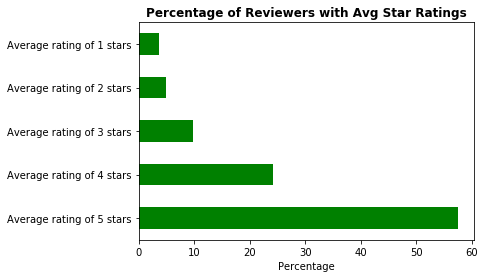

In [779]:
%matplotlib inline
import matplotlib.pyplot as plt

#Visualize average rating by users
g.pct.plot(kind = 'barh', color = 'g');
plt.title('Percentage of Reviewers with Avg Star Ratings', fontweight = 'bold');
plt.xlabel('Percentage');

We can see that almost 60% of users reliably rate books with 5 stars while about 8% reliably rate books with 1 or 2 stars.

Next, we'll evaluate which words are most commonly used across all reviews using the NLTK package.

In [104]:
from sklearn.feature_extraction.text import CountVectorizer
import string
import numpy as np
from nltk import word_tokenize          
from nltk.stem.porter import PorterStemmer

In [105]:
stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    """
    Produces lemmatized tokens using provided stemmer.
    """
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    """
    Tokenizes the text and returns stems of all tokens.
    """
    tokens = word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

#Vectorize with maximum of 100 features using default stopwords and only looking for unigrams
vect_one = CountVectorizer(max_features = 100, ngram_range = (1,1), stop_words = 'english', tokenizer = tokenize)
one_gram = vect_one.fit_transform(reviews_df.full_text)
X_one = one_gram.tocsc()

#Zip together words and their frequencies
freq_one = zip(vect_one.get_feature_names(), np.asarray(X_one.sum(axis=0)).ravel())
sort_freq_one = sorted(list(freq_one), key=lambda x: x[1], reverse = True)

In [135]:
#Print most frequent that are not punctuation marks
def check_punc(line):
    """
    Runs through all tokens and returns None if token is punctuation.
    Returns token if not punctuation.
    """
    for l in line[0]:
        if l in string.punctuation:
            return
    return line

no_punc = [(lambda x: check_punc(x))(x) for x in sort_freq_one]
short = [x for x in no_punc if x is not None]
for feature, score in short[0:20]:
    print('Feature is \"',feature, '\" with frequency',score)

Feature is " book " with frequency 1098512
Feature is " thi " with frequency 1033239
Feature is " wa " with frequency 769750
Feature is " read " with frequency 582223
Feature is " hi " with frequency 432373
Feature is " stori " with frequency 386095
Feature is " like " with frequency 315746
Feature is " love " with frequency 304099
Feature is " ha " with frequency 277895
Feature is " charact " with frequency 260829
Feature is " just " with frequency 229364
Feature is " time " with frequency 219879
Feature is " veri " with frequency 206714
Feature is " good " with frequency 205599
Feature is " did " with frequency 186531
Feature is " great " with frequency 181004
Feature is " realli " with frequency 178725
Feature is " make " with frequency 171384
Feature is " life " with frequency 160439
Feature is " end " with frequency 158431


Let's see how these look as a word cloud.

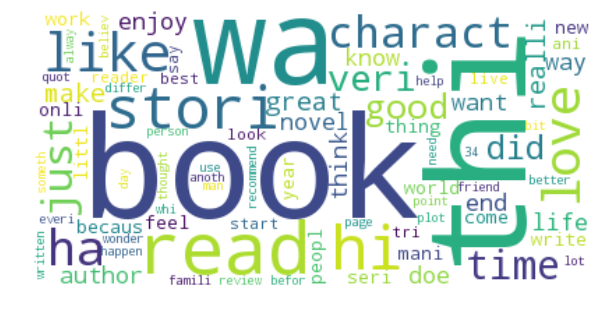

In [134]:
from wordcloud import WordCloud

d = dict(short)
wordcloud = WordCloud(background_color = 'white')
wordcloud.generate_from_frequencies(frequencies = d)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Now, let's run the same analysis with bi-grams.

In [ ]:
#del vect_one, one_gram, X_one

#Vectorize with maximum of 100 features using default stopwords and only looking for bi-grams
vect_two = CountVectorizer(max_features = 100, ngram_range = (2,2), stop_words = 'english', tokenizer = tokenize)
two_gram = vect_two.fit_transform(reviews_df.full_text)
X_two = two_gram.tocsc()

#Zip together words and their frequencies
freq_two = zip(vect_two.get_feature_names(), np.asarray(X_two.sum(axis=0)).ravel())
sort_freq_two = sorted(list(freq_two), key=lambda x: x[1], reverse = True)

In [86]:
#Print most frequent that are not punctuation marks
no_punc = [(lambda x: check_punc(x))(x) for x in sort_freq_two]
short = [x for x in no_punc if x is not None]
for feature, score in short:
    print('Feature is \"',feature, '\" with frequency',score)

Feature is " thi book " with frequency 368312
Feature is " read thi " with frequency 66198
Feature is " book wa " with frequency 48223
Feature is " thi wa " with frequency 40071
Feature is " read book " with frequency 34802
Feature is " thi stori " with frequency 32338
Feature is " love thi " with frequency 30928
Feature is " thi seri " with frequency 28045
Feature is " thi novel " with frequency 24794
Feature is " main charact " with frequency 23868
Feature is " enjoy thi " with frequency 23526
Feature is " like thi " with frequency 23258
Feature is " recommend thi " with frequency 23204
Feature is " book read " with frequency 21848
Feature is " wa veri " with frequency 20949


### Parts of Speech with spaCy

In [150]:
#import spaCy package
import en_core_web_sm
nlp = en_core_web_sm.load()

Do more glowing reviews use different parts of speech, for example, more adjectives?

In [185]:
from collections import Counter

def count_pos(score):
    """
    Count up all parts of speech for a given score
    """
    df = reviews_df[reviews_df.overall == score]
    tot_counted = Counter({'score':score})
    for index, row in df.iterrows():
        parsed_review = nlp(row.full_text)
        token_pos = [token.pos_ for token in parsed_review]
        tot_counted += Counter(token_pos)
    return tot_counted

#Run through all scores (1-5) and compile into dataframe
d = []
for i in range(1,6):
   d.append(count_pos(i))
pos_df = pd.DataFrame(d)
pos_df

       ADJ      ADP      ADV    CCONJ      DET   INTJ     NOUN     NUM  \
0   381155   427528   312244   144266   389606  10449   704255   39786   
1   585878   655310   499366   229832   601797  13455  1052325   54364   
2  1348382  1502798  1065716   533963  1380252  23982  2391431  118079   
3  2843600  3135207  1980486  1111871  2858961  38421  5085883  240811   
4  4367581  4752071  2944704  1712766  4350670  66731  7873306  391593   

      PART     PRON    PROPN    PUNCT   SPACE    SYM     VERB      X  score  
0   104747   249777   191962   515649   64303   4880   728257   2961      1  
1   162841   386777   265509   752897   93073   6397  1092237   3985      2  
2   364453   839951   656547  1636050  196335  13542  2395228   7734      3  
3   756735  1636126  1553089  3316003  388863  24792  4830653  15067      4  
4  1131466  2620857  2492849  5231708  661057  39972  7482930  25687      5  


In [251]:
#Set index to score
#pos_df = pos_df.set_index('score')

#Transpose to score columns
pos_dfT = pos_df.transpose()

#Divide by number of reviews for each score to normalize
for i in pos_dfT:
    count = reviews_df[reviews_df.overall == i].asin.count()
    pos_dfT[i] = pos_dfT[i].apply(func = lambda x: x / float(count))
pos_dfT

score,1,2,3,4,5
ADJ,19.185332,21.474892,22.276628,21.740726,16.700051
ADP,21.519505,24.019867,24.827735,23.970206,18.170202
ADV,15.716716,18.303863,17.606701,15.141793,11.259484
CCONJ,7.261590,8.424309,8.821606,8.500803,6.548998
DET,19.610711,22.058390,22.803152,21.858168,16.635389
INTJ,0.525948,0.493182,0.396207,0.293748,0.255155
NOUN,35.448482,38.572135,39.508847,38.884087,30.104676
NUM,2.002617,1.992669,1.950784,1.841119,1.497310
PART,5.272412,5.968807,6.021130,5.785613,4.326317
PRON,12.572457,14.177003,13.876836,12.508991,10.021210


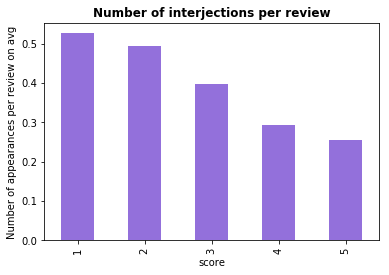

In [631]:
#Plot average number of interjections per review for a given score
pos_dfT.transpose().INTJ.plot(kind = 'bar', color = 'mediumpurple');
plt.ylabel('Number of appearances per review on avg');
plt.title('Number of interjections per review', fontweight = 'bold');

There does not appear to be a significant difference between scores for adjectives but interjections decrease with score.

## Naive Bayes Modeling

We begin our analysis by training a Naive Bayes model to gauge sentiment classification on the book review text.

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where c represents the classification of each star rating and f represents a feature vector of words.  Therefore, we are finding the probability of a rating given a certain bag-of-words representation of a textual book review.

In [87]:
#First vectorize text and create series of scores as y
def make_xy(df, vectorizer):    
    X = vectorizer.fit_transform(df.full_text)
    X = X.tocsc() 
    y = df.overall.values
    return X, y

vectorizer = CountVectorizer(stop_words = 'english', max_df = 0.9)
X, y = make_xy(reviews_df, vectorizer)

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

#Split into training (70%) and test (30%) sets
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.3, random_state = 10)
clf = MultinomialNB()

#Fit classifier on the training sets
clf.fit(xtrain, ytrain)

#Calculate accuracy score of model's predictions on both sets
test_score = accuracy_score(clf.predict(xtest), ytest)
train_score = accuracy_score(clf.predict(xtrain), ytrain)
print('Accuracy of training set: {:.2f} \nAccuracy of test set: {:.2f}'.format(train_score, test_score))

Accuracy of training set: 0.67 
Accuracy of test set: 0.60


Accuracy on both the training and test sets are very similar, indicating that this model is not overfit, but accuracy is on the low side.

In [89]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[ 1494  1362  1623   387  1216]
 [  461  1237  4073  1078  1430]
 [  344   545  7558  5395  4270]
 [  374   159  4500 15943 18135]
 [  821   188  1780 11839 63790]]


Let's do some grid search optimization to ensure our default alpha of 1.0 returns the best results.

In [90]:
from sklearn.model_selection import GridSearchCV

parameters = {'alpha':[.1, 1, 5, 10, 50]}
clf = MultinomialNB()

clf_gs = GridSearchCV(clf, parameters)
clf_gs.fit(xtrain, ytrain)

GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [0.1, 1, 5, 10, 50]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [91]:
#Return results as dataframe
pd.DataFrame(clf_gs.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,1.211323,0.170201,0.578638,0.717482,0.1,{'alpha': 0.1},2,0.581723,0.719201,0.577948,0.716292,0.576243,0.716954,0.036528,0.005760,0.002290,0.001245
1,1.248969,0.192456,0.598615,0.675420,1,{'alpha': 1},1,0.599731,0.675019,0.600096,0.674897,0.596018,0.676344,0.056778,0.018842,0.001843,0.000655
2,1.262332,0.190667,0.560029,0.580559,5,{'alpha': 5},3,0.560132,0.579594,0.560728,0.580804,0.559229,0.581279,0.022096,0.003858,0.000616,0.000710
3,1.263000,0.194331,0.534181,0.539587,10,{'alpha': 10},4,0.533741,0.539193,0.534371,0.539632,0.534432,0.539936,0.020831,0.006127,0.000312,0.000305
4,1.265333,0.207998,0.523218,0.523253,50,{'alpha': 50},5,0.523198,0.523250,0.523245,0.523261,0.523212,0.523247,0.025952,0.011863,0.000020,0.000006


We've confirmed that an alpha of 1.0 returns the highest accuracy score but let's explore other values around 1.0 to ensure this is the true maximum.

In [92]:
parameters = {'alpha':[.6,.8,1,2.0,4.0]}
clf = MultinomialNB()

clf_gs = GridSearchCV(clf, parameters)
clf_gs.fit(xtrain, ytrain)

pd.DataFrame(clf_gs.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,1.265334,0.189668,0.597415,0.693810,0.6,{'alpha': 0.6},3,0.599602,0.694138,0.597345,0.693046,0.595298,0.694245,0.031007,0.000471,0.001758,0.000541
1,1.260669,0.190667,0.598698,0.684574,0.8,{'alpha': 0.8},1,0.600288,0.684551,0.599693,0.684132,0.596112,0.685039,0.017556,0.002055,0.001844,0.000371
2,1.252736,0.198888,0.598615,0.675420,1,{'alpha': 1},2,0.599731,0.675019,0.600096,0.674897,0.596018,0.676344,0.006328,0.009039,0.001843,0.000655
3,1.294196,0.204941,0.588804,0.637129,2,{'alpha': 2.0},4,0.589077,0.636255,0.590119,0.636493,0.587215,0.638639,0.024567,0.016222,0.001201,0.001072
4,1.205044,0.188372,0.568409,0.594665,4,{'alpha': 4.0},5,0.568129,0.593994,0.569496,0.594489,0.567603,0.595512,0.029902,0.003734,0.000798,0.000632


Further tuning shows us that alpha = 0.8 returns the maximum accuracy (59.9% on the test set) for this model.

Let's see how the model predicts a new reviews.  I pulled this 5-star review from Amazon for Hillbilly Elegy.

In [93]:
#Check that Hillbilly Elegy (published 2016) is not included in dataset 
'Hillbilly Elegy' in reviews_df.title

False

In [98]:
#Fit classifier with optimized alpha to training set
clf = MultinomialNB(alpha = 0.8).fit(xtrain, ytrain)

#Vectorize review based on vocabulary from dataset
new_review = 'This Harvard Law grad finally has a Yale man he can respect. I grew up without running water in Boone County, WV, and wound up with a degree from Harvard Law School. JD Vance\'s story brought me to tears and cheers, for he has told the story of my people.'
new_review_vect = vectorizer.transform([new_review])

print('Predicted rating:', clf.predict(new_review_vect))
print('Probability of each score:', clf.predict_proba(new_review_vect))

Predicted rating: [ 5.]
Probability of each score: [[  1.27511943e-04   2.93498964e-04   2.15565893e-03   9.65063620e-02
    9.00916968e-01]]


The model has predicted with more 90% certainty that this is a 5-star review, even though the review does not contain giveaway words like "love" or "enjoy".

Let's see how the model performs with a negative review.  Below is a one-star review for Hillbilly Elegy.

In [99]:
new_review = 'Insulting Trash. Classicism to the tenth degree. No actual analytical thought in how circumstances out of the individuals control contributed to their plight. Also, don\'t degrade a whole society based on your own trashy family. Also, the author seems to think he\'s special. He\'s not, he had decent grandparents so he had some good influences that contributed to his success. He should focus more on that instead of his mommy daddy issues.'
new_review_vect = vectorizer.transform([new_review])

print('Predicted rating:', clf.predict(new_review_vect))
print('Probability of each score:', clf.predict_proba(new_review_vect))

Predicted rating: [ 1.]
Probability of each score: [[ 0.49618968  0.29386351  0.11600829  0.07979484  0.01414367]]


The model isn't as sure as the positive review above but has predicted that this review is negative.

How does the model perform with a 3-star or so-so review?  I pulled a 3-star review again from Hillbilly Elegy below.

In [100]:
new_review = 'Good, but no real surprises. I enjoyed reading this memoir because of the fact it was a memoir and, if well written, I am generally intrigued by the lives of others. However, one of the big hypes of the book was it supposedly contained the answers to why so many voted for Trump. I didn\'t find any fascinating revelations on that issue and am still stupefied by it. There were some interesting statistics though and, overall, it was a good read. I\'m sure there will be good discussions at book group tonight!'
new_review_vect = vectorizer.transform([new_review])

print('Predicted rating:', clf.predict(new_review_vect))
print('Probability of each score:', clf.predict_proba(new_review_vect))

Predicted rating: [ 4.]
Probability of each score: [[  3.45320176e-06   5.14111777e-02   1.39215405e-01   7.21206761e-01
    8.81632025e-02]]


The model has made an incorrect classification here, though we can see that the correct classification (3) was the next most probable answer.

## Data Cleaning - Phrase Modeling

Now we'll use the spaCy package to more efficiently parse and lemmatize the review text and eventually model the prevalent topics in all 5-star reviews.

In [318]:
import os
import codecs

review_txt_filepath = r'C:\Users\mdris\Documents\Capstone2\review_text.txt'

#Create text file containing text of all 5-star reviews
np.savetxt(review_txt_filepath, reviews_df.full_text[reviews_df.overall == 5].values, fmt='%s')

In [443]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.models.word2vec import LineSentence

In [334]:
def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    return token.is_punct or token.is_space

def line_review(filename):
    """
    generator function to read in reviews from the file
    """ 
    with codecs.open(filename, encoding='utf_8') as f:
        for review in f:
            yield review
            
def lemmatized_sentence_corpus(filename):
    """
    generator function to use spaCy to parse reviews and lemmatize text
    """
    for parsed_review in nlp.pipe(line_review(filename), batch_size=10000, n_threads=4):    
        yield u' '.join([token.lemma_ for token in parsed_review if not punct_space(token)])

In [336]:
unigram_reviews_filepath = r'C:\Users\mdris\Documents\Capstone2\unigrams_txt.txt'

#Write parsed and lemmatized reviews to new text file
with codecs.open(unigram_reviews_filepath, 'w', encoding='utf_8') as f:
    for review in lemmatized_sentence_corpus(review_txt_filepath):
        f.write(review + '\n')

#Set up unigram sentences as a line generator
unigram_reviews = LineSentence(unigram_reviews_filepath)

In [339]:
import itertools as it

#Read a portion of the parsed reviews
for unigram_review in it.islice(unigram_reviews, 345, 350):
    print (' '.join(unigram_review))
    print ('')

water for elephant -PRON- purchase this book as a gift for -PRON- daughter which -PRON- love -PRON- give -PRON- a great review therefore -PRON- can recommend the book to -PRON-

great book -PRON- could not put this book down an excellent story easy read and fun now -PRON- can not wait to see the movie

what take -PRON- so long what take -PRON- so long to discover this book -PRON- have not hear about -PRON- from anyone just find -PRON- during a browse -PRON- have be look for a good read for so long and water for elephant be right there the whole time -PRON- can not wait to read sara gruen 's other book and when -PRON- finish -PRON- -PRON- new one should be available -PRON- bring to life the good the bad and the ugly of the circus world and -PRON- character be vivid and full of life -PRON- find -PRON- completely engross in the character and fall in love with the main animal -PRON- could not wait to get to the next page and the end be worth the whole trip for -PRON- -PRON- be one of those

Instead of trying to lemmatize pronouns (such as "me" to "I"), spaCy returns "-PRON-".  As we are only interested in topic modeling, this has no effect on the end result.

Now that we've parsed into unigrams, we can run spaCy's Phrases model to find and group bi-grams.

In [444]:
#Train bigram model
bigram_model = Phrases(unigram_reviews)
bigram_phraser = Phraser(bigram_model)

bigram_reviews_filepath = r'C:\Users\mdris\Documents\Capstone2\bigram_reviews.txt'

#Run each review through the bigram model and write resulting review to new text file
with codecs.open(bigram_reviews_filepath, 'w', encoding='utf_8') as f:
    for unigram_review in unigram_reviews:
        bigram_review = u' '.join(bigram_phraser[unigram_review])
        f.write(bigram_review + '\n')
        
bigram_reviews = LineSentence(bigram_reviews_filepath)

In [445]:
#View same slice of reviews as unigram sentences above
for bigram_review in it.islice(bigram_reviews, 345, 350):
    print (u' '.join(bigram_review))
    print ('')

water for elephant -PRON- purchase this book as a gift for -PRON- daughter which -PRON- love -PRON- give -PRON- a great review therefore -PRON- can recommend the book to -PRON-

great book -PRON- could not put this book down an_excellent story easy read and fun now -PRON- can not wait to see the movie

what take -PRON- so long what take -PRON- so long to discover this book -PRON- have not hear about -PRON- from anyone just find -PRON- during a browse -PRON- have be look for a good read for so long and water for elephant be right there the whole time -PRON- can not wait to read sara_gruen 's other book and when -PRON- finish -PRON- -PRON- new one should be available -PRON- bring to life the good the bad and the ugly of the circus world and -PRON- character be vivid and full of life -PRON- find -PRON- completely_engross in the character and fall in love with the main animal -PRON- could not wait to get to the next page and the end be worth the whole trip for -PRON- -PRON- be one of those

We can see that the bigram model has picked out "nursing home", "completely engross", and "unabridged audio" as two-word phrases.  Surprisingly the model did not group "old man" or "book club".

In [642]:
#Finally we'll remove stopwords and pronouns and write back to the a final text file
transformed_reviews_filepath = r'C:\Users\mdris\Documents\Capstone2\transformed_txt.txt'

with codecs.open(transformed_reviews_filepath, 'w', encoding='utf_8') as f:
    for review in bigram_reviews:
        transformed_review = [term for term in review if (term != '-PRON-' and term != '\'s' and term not in spacy.en.English.Defaults.stop_words)]
        transformed_review = u' '.join(transformed_review)
        f.write(transformed_review + '\n')

In [773]:
print(u'Original:' + u'\n')

for review in it.islice(line_review(review_txt_filepath), 17, 18):
    print(review)

print(u'----' + u'\n')
print(u'Transformed:' + u'\n')

with codecs.open(transformed_reviews_filepath, encoding='utf_8') as f:
    for review in it.islice(f, 17, 18):
        print(review)

Original:

Flawless. Anything I've read by Gibran is, in my mind, flawless. This, the most famous of his works, is no exception. It is simple, yet deep; honest and profound; moving and inspirational. Gibran's work is one of a kind, and can be far more encouraging and moving than any self-help program or therapy or anything like that. The poetic style, the aphorisms, the parables, the almost biblical feel, are all just what over-worked, over-stressed, modern and spiritually starved worldly people need.

----

Transformed:

flawless read gibran mind flawless most_famous work no_exception simple deep honest profound inspirational gibran work kind far encouraging self help program therapy like poetic style aphorism parable biblical feel work stress modern spiritually starve worldly people ne



As we can see, spaCy has severely pruned this review down to only a few key words.

## LDA Topic Modeling

In [345]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim
import warnings

In [644]:
review_dictionary_filepath = r'C:\Users\mdris\Documents\Capstone2\transformed_dict.txt'

reviews = LineSentence(transformed_reviews_filepath)

# learn the dictionary (bag of words) by iterating over all of the reviews
review_dictionary = Dictionary(reviews)
    
# filter tokens that are very rare or too common from dictionary (filter_extremes) and reassign integer ids (compactify)
review_dictionary.filter_extremes(no_below=10, no_above=0.4)
review_dictionary.compactify()

review_dictionary.save(review_dictionary_filepath)

In [645]:
def bow_generator(filepath):
    """
    generator function to read reviews from a file and yield a bag-of-words representation
    """
    for review in LineSentence(filepath):
        yield review_dictionary.doc2bow(review)

In [646]:
# load the finished dictionary from disk
review_dictionary = Dictionary.load(review_dictionary_filepath)

transformed_bow_filepath = r'C:\Users\mdris\Documents\Capstone2\transformed_bow.txt'

#Generate bag of words for all reviews and save as matrix
MmCorpus.serialize(transformed_bow_filepath, bow_generator(transformed_reviews_filepath))
    
#Load from disk
review_bow_corpus = MmCorpus(transformed_bow_filepath)

In [647]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda = LdaMulticore(review_bow_corpus, num_topics=50, id2word=review_dictionary, workers=3)

In [679]:
def explore_topic(topic_number, topn=25):
    """
    accept a user-supplied topic number and print out a formatted list of the top terms
    """
    print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')

    for term, frequency in lda.show_topic(topic_number, topn=25):
        print(u'{:20} {:.3f}'.format(term, frequency))

In [704]:
explore_topic(topic_number=48)

term                 frequency

juliette             0.017
like                 0.010
story                0.008
know                 0.008
love                 0.007
way                  0.006
amy                  0.006
world                0.006
man                  0.005
girl                 0.005
find                 0.004
feel                 0.004
chris                0.004
write                0.004
life                 0.004
time                 0.004
beautiful            0.004
come                 0.004
allon                0.004
moore                0.004
tell                 0.004
character            0.004
bliss                0.004
beauty               0.004
good                 0.003


In [774]:
topic_names = {0: u'rome',
               1: u'sports, monsters',
               2: u'christianity',
               3: u'general',
               4: u'character',
               5: u'sci-fi',
               6: u'humankind',
               7: u'contractions',
               8: u'general',
               9: u'general',
               10: u'women',
               11: u'good, great',
               12: u'world, experience',
               13: u'life, people',
               14: u'general',
               15: u'love, like',
               16: u'family relationships',
               17: u'story, family',
               18: u'physical book',
               19: u'plot',
               20: u'male names',
               21: u'angel',
               22: u'general',
               23: u'paranormal',
               24: u'history',
               25: u'story',
               26: u'america',
               27: u'humor',
               28: u'fantasy',
               29: u'general',
               30: u'good, great',
               31: u'jewish history',
               32: u'american military',
               33: u'survival',
               34: u'fairy tale',
               35: u'like, love',
               36: u'self-help',
               37: u'story',
               38: u'family',
               39: u'cookbook',
               40: u'general',
               41: u'series',
               42: u'murder mystery',
               43: u'technical',
               44: u'general',
               45: u'novel',
               46: u'dallas',
               47: u'children',
               48: u'general',
               49: u'female names'}

Certain topics like #27, containing terms like "laugh", "funny", "hilarious", were easy to classify.  In this case, #27 was defined as humor.  Some were less definite.  Topic #18 contained terms like "word", "art", "edition", "illustration" and was classified as "physical book" to indicate features pertaining to the book itself. Others were simply classified as "general", such as #48.  I could not find an overarching theme to "juliette", "like", "know".

In [705]:
LDAvis_prepared = pyLDAvis.gensim.prepare(lda, review_bow_corpus, review_dictionary)
pyLDAvis.display(LDAvis_prepared)

C:\Users\mdris\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]


Scrolling over love to determine which topics have the strongest relationship to that term, we see the circles to the left grow much bigger and the right circles shrink.  Likewise, when we scroll over "war", the circles on the right grow and on the left shrink.  The model has learned that "war" and "love" are opposites.  

### Application of LDA Model to Review Text

In order to use this model to reviews with from our dataframe, we'll need to run each text through the pipeline created above (parse, lemmatize, link bi-grams, create bag-of-words) before applying the LDA model trained previously to extract the most relevant topics.

In [706]:
def lda_description(review_text):
    """
    Parses, lemmatizes, finds bi-grams and omits stop words. 
    Converts to bag-of-words vector and returns topics from LDA model sorted by relevancy.
    """
    # parse the review text with spaCy
    parsed_review = nlp(review_text)
    
    # lemmatize the text and remove punctuation and whitespace
    unigram_review = [token.lemma_ for token in parsed_review if not punct_space(token)]
    
    # apply the first-order phrase models
    bigram_review = bigram_phraser[unigram_review]
    
    # remove any remaining stopwords
    bigram_review = [term for term in bigram_review if (term != '-PRON-' and term not in spacy.en.English.Defaults.stop_words)]
    
    # create a bag-of-words representation
    review_bow = review_dictionary.doc2bow(bigram_review)
    
    # create an LDA representation
    review_lda = lda[review_bow]
   
    # sort with the most highly related topics first
    review_lda = sorted(review_lda, key = lambda tup: tup[1], reverse = True)
    
    return review_lda

def print_lda_description(review_text, min_topic_freq=0.05):
    """
    Prints most relevant topics from LDA model over minimum frequency threshold.
    """
    for topic_number, freq in lda_description(review_text):
        if freq < min_topic_freq:
            break
        # print the most highly related topic names and frequencies
        print('{:25} {}'.format(topic_names[topic_number], round(freq, 3)))

In [734]:
#Pull a 5-star review
review = reviews_df[reviews_df.overall == 5].full_text[83]
print(review)

Words to Live By and Learn From. A must in everyone's library for graceful poetry, inpirational reading and lessons to live by and to even to let go.  A new printing would be a welcome as the "used" ones in good condition are quite expensive.


In [735]:
#Print dominant themes
print_lda_description(review)

physical book             0.493
life, people              0.271
good, great               0.184


We can see that the model picked up on the "physical book" topic from the last sentence about printing.  

In [752]:
#Pull a 5-star review
review = reviews_df[reviews_df.overall == 5].full_text[74]
print(review)

Residing in my mind..... Residing in my mind are the words of a true poet.  I was given the book THE PROPHET by my best friend when I was young.  It has followed me through my life and has filled me with the emotions and practical thought I needed to guide me through the smooth and rough waters of my life.  I gave this copy of Kahil Gibran's book to a young lady with the hope she will enjoy it the rest of her life.  Thank you Amazon for having this wonderful work of art available to all.


In [753]:
#Print dominant themes from review
print_lda_description(review)

physical book             0.257
world, experience         0.228
life, people              0.18
story                     0.164
family                    0.146


Again the "physical book" theme has reappeared when the reviewer mentioned the "copy" of the book he/she gave to another.  The other dominant themes are "world, experience" and "life, people" as the reviewer writes about how the book has impacted his/her life and outlook.

### Theme-based Recommender System

We can create a recommender system to match users with titles that the model identifies as containing the same themes as books the user has reviewed favorably (5-star rating).

In [760]:
import itertools

#Create recommender system
def find_themes(review_text):
    """
    Helper function to find most relevant themes (relevance greater than 0.05) in review text.
    """
    themes = [tuple for tuple in lda_description(review_text) if tuple[1] > 0.05] 
    return [tuple[0] for tuple in themes]

def find_user_themes(reviewerID):
    """
    Helper function to find 3 most commonly returned themes from LDA model's analysis of reviewer's text.
    """
    themes = []
    five_star_reviews = reviews_df[(reviews_df.overall == 5) & (reviews_df.reviewerID == reviewerID)].full_text
    for review in five_star_reviews:
        themes.append(find_themes(review))
    c = Counter([item for sublist in themes for item in sublist])
    return [tup[0] for tup in c.most_common(3)]

def recommend_books(reviewerID):
    """
    Iterate through dataframe of 5-star reviews to find matching themes to those reviewed favorably by user. 
    Returns list of titles with matching themes.
    """
    #Initialize empty list for recommended titles
    titles = []
    
    #Find target themes from user's reviews
    target_themes = find_user_themes(reviewerID)
    print('Target themes:', target_themes)
    #Run through database of 5-star reviews and find matching themes
    for index, row in reviews_df[reviews_df.overall == 5].iterrows():
        themes = find_themes(row.full_text)
        for theme in themes:
            if theme in target_themes and row.title not in titles:
                titles.append(row.title)
    return titles

In [716]:
#Test with a reviewer
reviewer = 'A010997525FU27TAPMJCG'
books = recommend_books(reviewer)
print('Number of titles found:', len(books))

Target themes: [13, 35, 36]
Number of titles found: 10505


The recommender system found many books that matched the user's theme preferences.  This model can be fine-tuned to more specific themes that more closely match the user's interests or that takes into account certain user characteristics.

In [718]:
#Identify books user rated highly
print(reviews_df[(reviews_df.reviewerID == 'A010997525FU27TAPMJCG') & (reviews_df.overall == 5)].title)

18498                         The Monk Who Sold His Ferrari
162799               The Zahir: A Novel of Obsession (P.S.)
167988                                      Brave New World
223112                                        The Alchemist
245946    The Greatness Guide: 101 Lessons for Making Wh...
276428    Start Where You Are: Life Lessons in Getting f...
Name: title, dtype: object


In [768]:
#Pull a sample of the books recommended
print('Sample of titles returned:')
print(books[72])
print(books[442])
print(books[3867])

Sample of titles returned:
Big Fish
Shadowmagic: Prince of Hazel and Oak
The Hair Color Mix Book: More Than 150 Recipes for Salon-Perfect Color at Home


This user rated certain self-help books highly as well as Brave New World.  The recommender system returned titles related to fantasy (Big Fish and Shadowmagic), presumably to match the sci-fy theme in Brave New World and the Alchemist.  The recommender system also suggested "The Hair Color Mix Book", perhaps identifying it as a type of self-help book.

In [776]:
#Find reviewer's name
reviews_df[reviews_df.reviewerID == reviewer]

,asin,helpful,overall,reviewerID,reviewerName,title,full_text
18498,0007179731,"[1, 1]",5.0,A010997525FU27TAPMJCG,"Aistis Zidanavicius ""Aistis Zidanavicius""",The Monk Who Sold His Ferrari,The Monk Who Sold His Ferrari. A wisdomfull st...
162799,0060832819,"[1, 1]",5.0,A010997525FU27TAPMJCG,"Aistis Zidanavicius ""Aistis Zidanavicius""",The Zahir: A Novel of Obsession (P.S.),The Zahir. Amazing journey to discover yoursel...
167988,0060850523,"[1, 1]",5.0,A010997525FU27TAPMJCG,"Aistis Zidanavicius ""Aistis Zidanavicius""",Brave New World,"Brave New World. Are you alpha, beta, gamma, d..."
223112,0061122416,"[2, 2]",5.0,A010997525FU27TAPMJCG,"Aistis Zidanavicius ""Aistis Zidanavicius""",The Alchemist,The Alchemist. Do live your own Personal Legen...
245946,0061238570,"[1, 1]",5.0,A010997525FU27TAPMJCG,"Aistis Zidanavicius ""Aistis Zidanavicius""",The Greatness Guide: 101 Lessons for Making Wh...,The Greatness Guide. Wisdom worth greatness!. ...
276428,006153711X,"[2, 2]",5.0,A010997525FU27TAPMJCG,"Aistis Zidanavicius ""Aistis Zidanavicius""",Start Where You Are: Life Lessons in Getting f...,Start Where You Are. Unbeatable will and persi...
